# P2. Titanic: Machine Learning from Disaster 2

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

The goal of this project is to create a model capable of predicting which passengers survived the Titanic shipwreck.

## 1. Initialising libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,
        font_scale = 1.5, color_codes=True)
from scipy.stats import randint
import math
import scipy

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.compose import ColumnTransformer 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

## 2. Exploratory Data Analysis


In [2]:
titanic_raw = pd.read_csv("C:/Users/user/Documents/Q/datasets/titanic/train.csv", index_col="PassengerId", encoding="latin1")

In [3]:
titanic_raw.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have replaced the `Id` column with the `PassengerId`.

- Our target attribute is `Survived` where 0 = No and 1 = Yes. 
- The `pclass` column refers to the class of the passengers and ranges from 1 (Upper) - 3 (Lower) class. 
- Where `Age` is fractional, it is less than 1. 
- When `parch` = 0, the data refers to children travelling with a nanny
- `parch` and `sibsp` maybe be combineable depending on importance
- `Cabin` seems to have missing values but theoretically should be very important
- `Embarked` has three classes: S (Southampton), Q (Queenstown) and C (Cherbourg)
- `Name` attribute needs to be cleaned up, surnames and/or titles may be more important
- `Ticket` should be irrelevant, must investigate and clean if necessary
- `Fare`, `Class` and `Age` may be more important

In [4]:
titanic_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
titanic_raw.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

We have 80% of the data for `Age`, only 23% of the data for `Cabin` and `Embarked` has two missing values. All these missing values must be dealt with.

In [6]:
titanic_raw.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Bulk of the `fare` prices fall under $31
- Most people aged less than 40yo

The features we are working with are as follows:

In [7]:
features = titanic_raw.columns.tolist()
features

['Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

### 2.1 Pclass

Here we plot `Pclass` against the corresponding number of passengers to understand the distribution of this attribute.

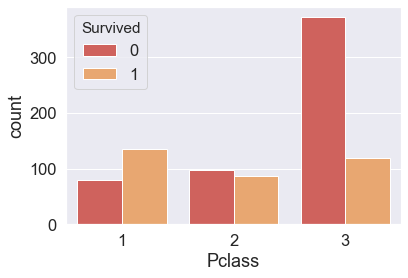

In [8]:
sns.countplot(x="Pclass", hue = "Survived", data=titanic_raw)
plt.show()

It is clear that individuals that were considered third-class had the highest mortality rate, with survival dropping off sharply in upper-class passengers. This likely has to do with where these upper class passengers were situated within the ship, or it implies these passengers were given priority in escaping. Either way, the higher the financial status of an individual on average, the more likely they were to survive.

### 2.2 Name

The format of the data corresponding to the `Name` attribute is ['Surname','Title' 'Forenames'].

In [9]:
[titanic_raw['Name'][:5]]

[PassengerId
 1                              Braund, Mr. Owen Harris
 2    Cumings, Mrs. John Bradley (Florence Briggs Th...
 3                               Heikkinen, Miss. Laina
 4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
 5                             Allen, Mr. William Henry
 Name: Name, dtype: object]

This format can be manipulated to extract the `Title` and `Surname` of passengers. However, I expect the frequency of `Surname` to be a more important attribute as those with the same surnames are obviously travelling together and are also more likely to be situated within the same areas on the ship at the time of disaster.

In [10]:
surnames = []
titles = []

full_names = titanic_raw["Name"]
for name in full_names:
    name = str(name)
    sur = name.split(",")[0]
    rest = name.split(",")[1]
    title = rest.split(".")[0]
    surnames.append(sur)
    titles.append(title)

In [11]:
surnames[:5], titles[:5]

(['Braund', 'Cumings', 'Heikkinen', 'Futrelle', 'Allen'],
 [' Mr', ' Mrs', ' Miss', ' Mrs', ' Mr'])

In [12]:
titanic_raw['Title'] = titles
titanic_raw['Surname'] = surnames
titanic_raw.drop('Name', axis=1, inplace=True)

In [13]:
titanic_raw.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen
4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen


In [14]:
titanic_raw['Title'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Major             2
 Col               2
 Mlle              2
 Ms                1
 the Countess      1
 Jonkheer          1
 Capt              1
 Lady              1
 Mme               1
 Sir               1
 Don               1
Name: Title, dtype: int64

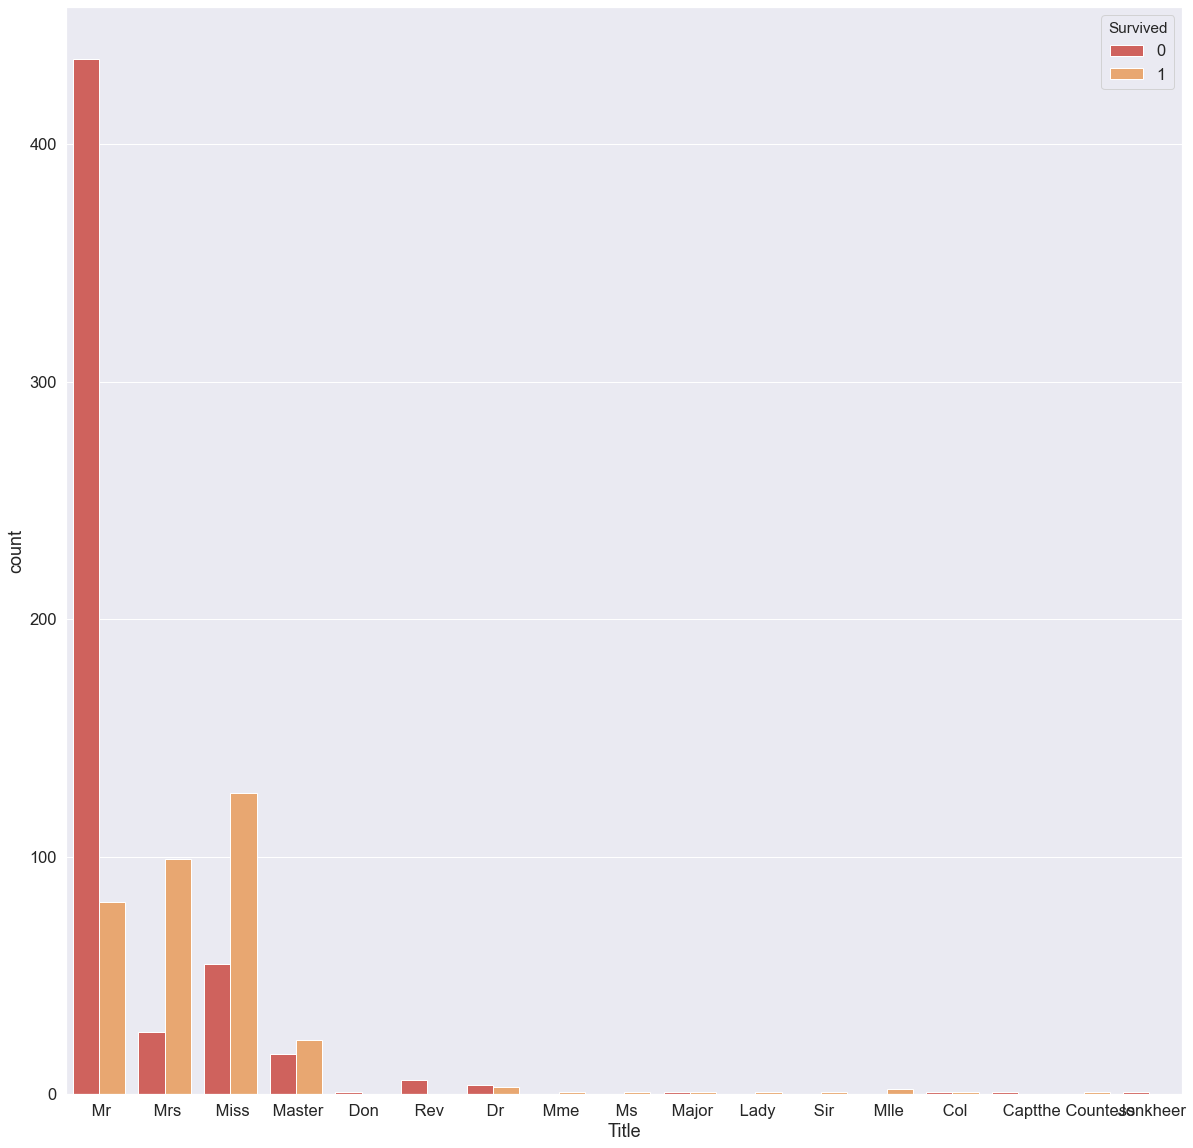

In [15]:
plt.figure(figsize=(20, 20))
sns.countplot(x="Title", hue="Survived", data=titanic_raw)
plt.show()

There are far too many unique categories under the `Title` attribute. We can group these up into 3 categories: `Mr`, `Mrs/Miss/Mme/Ms/Mlle`, `Trained/Nobility` later during the feature engineering portion.

Lastly, we create a `Family Size` attribute which we can discretize later:

In [16]:
titanic_raw['Family Size'] = titanic_raw.groupby('Surname')['Surname'].transform('count')

- `Alone`: 1
- `Small`: 2 - 3
- `Medium`: 4 - 6
- `Large`: 7 - 11

### 2.3 Sex

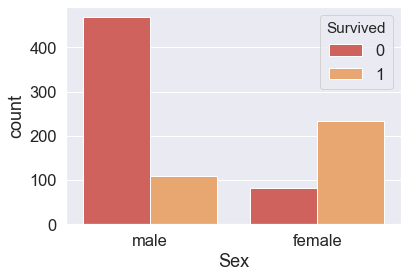

In [17]:
sns.countplot(x="Sex", hue='Survived', data=titanic_raw)
plt.show()

We can see that a large proportion of male passengers did not survive, on the other hand, females had a much higher survival rate

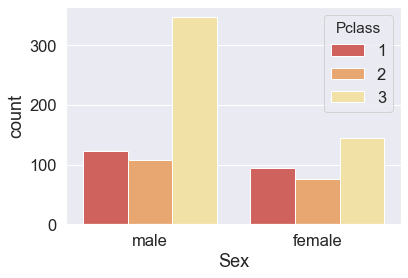

In [18]:
sns.countplot(x="Sex", hue='Pclass', data=titanic_raw)
plt.show()

### 2.4 Age

We have `Age`-data missing for 177 passengers which we need to replace. These replacement values will be dependant on the relationship between `Age` and other attributes.

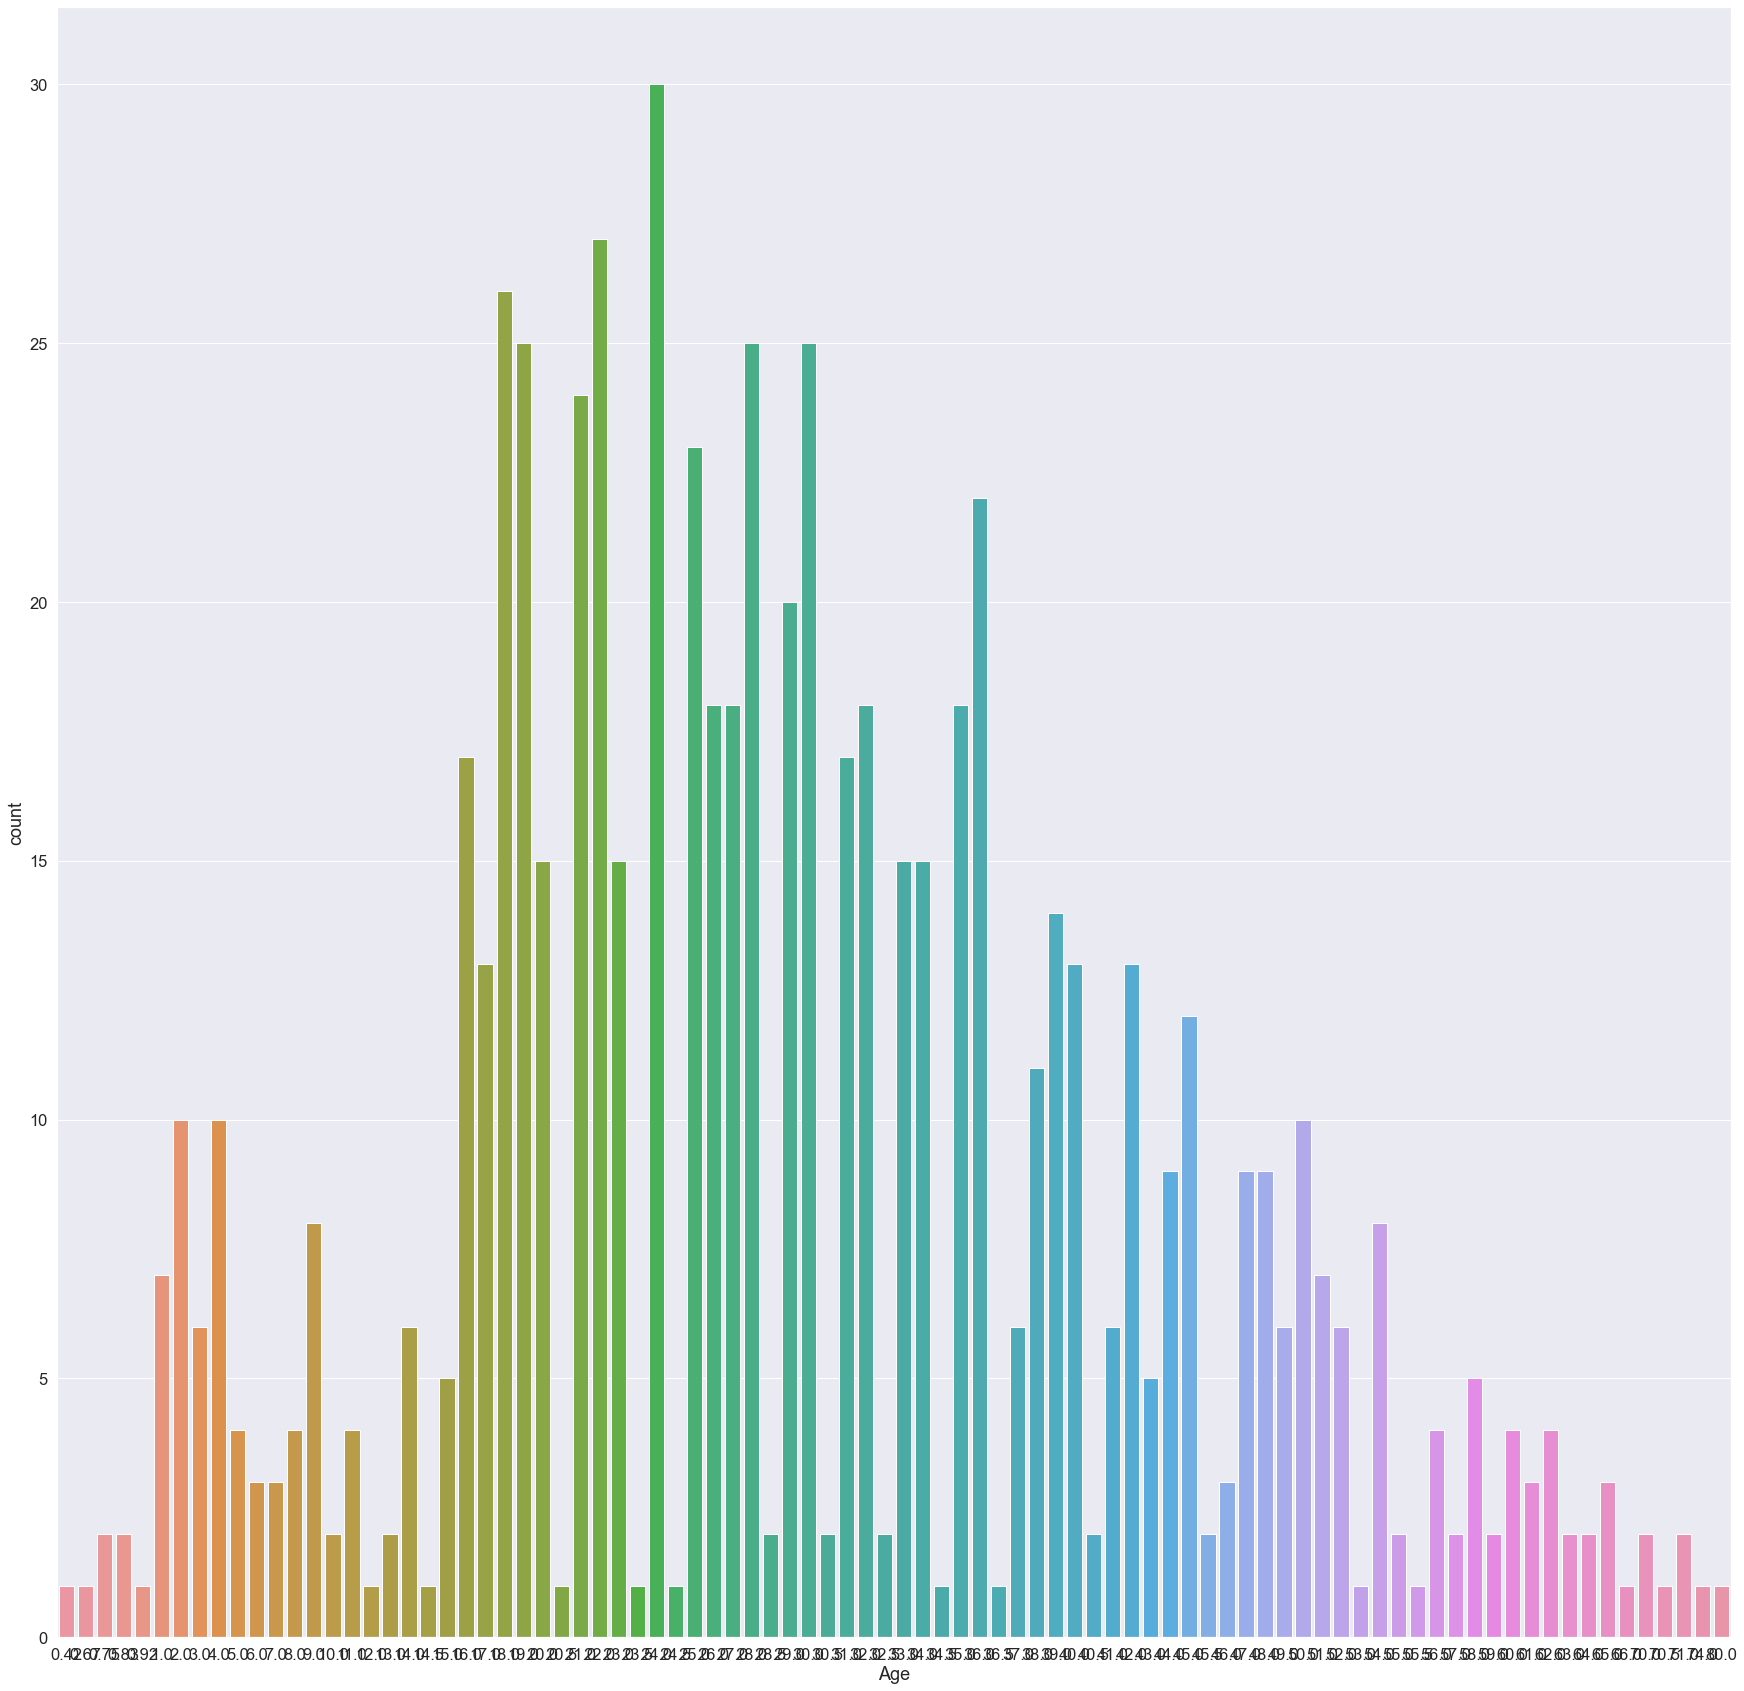

In [19]:
plt.figure(figsize=(30, 30))
sns.countplot(x="Age", data=titanic_raw)
plt.show()

#### Missing values

In [20]:
corr_matrix = titanic_raw.corr()
corr_matrix["Age"].sort_values(ascending=False)

Age            1.000000
Fare           0.096067
Survived      -0.077221
Parch         -0.189119
Family Size   -0.227600
SibSp         -0.308247
Pclass        -0.369226
Name: Age, dtype: float64

So we see that `Age` is strongly but negatively correlated with `Pclass` and `SibSp`.

It is likely that the number of male and female passengers varies greatly for almost all age-brackets, therefore it is a good idea to fill in the missing data based on the average age for the corresponding `Pclass` as well as the `Sex`. Given the skewed distribution of `Age`, it is viable to compute the median value for a given criterion.

In [21]:
titanic_raw['Age'] = titanic_raw.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [22]:
titanic_raw.isnull().sum()

Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
Surname          0
Family Size      0
dtype: int64

#### Visualisation

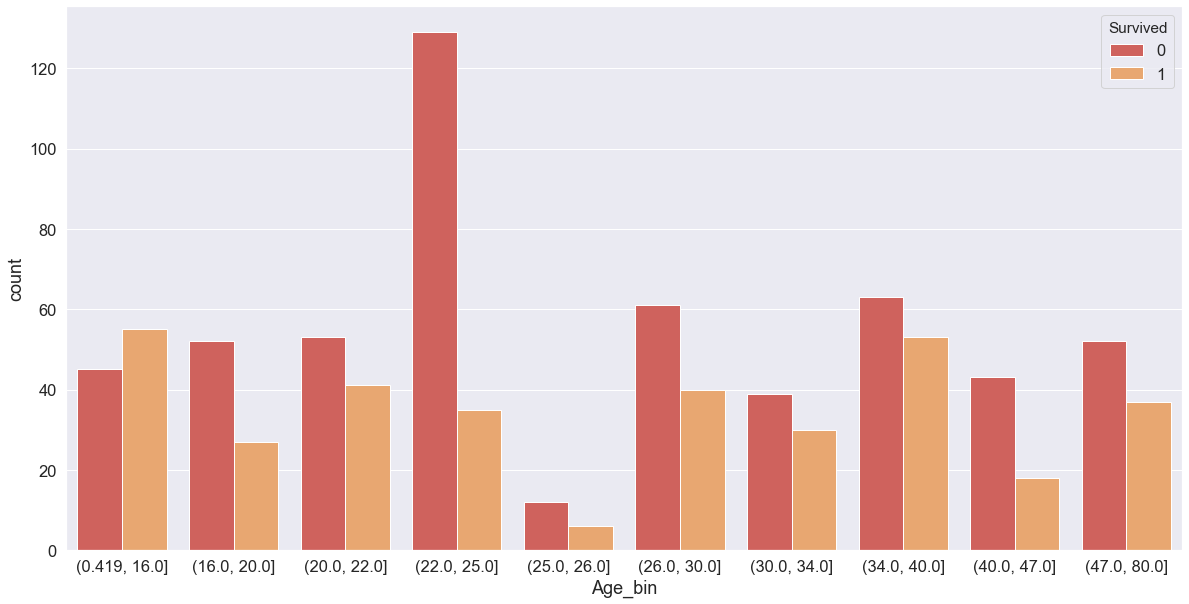

In [23]:
titanic_raw['Age_bin'] = pd.qcut(titanic_raw['Age'], 10, duplicates='drop')

plt.figure(figsize=(20, 10))

sns.countplot(x="Age_bin", hue="Survived", data=titanic_raw)
plt.show()

In [24]:
def survival_rate(col):
    
    surv_perc = []
    unique_values = titanic_raw[col].unique() 
    
    for row in unique_values:
        
        subset = titanic_raw[titanic_raw[col] == row]
        survived = subset[subset['Survived'] == 1].shape[0]
        survival = survived / subset.shape[0]
        survival = np.round(survival*100)
        print("The Survival Rate for {}:{} was {}% among {} passengers".format(col, row, survival, subset.shape[0]))
        surv_perc.append(survival)
        
    rate_df = pd.DataFrame(unique_values, columns=[col])
    rate_df['Survival Rate'] = surv_perc
    
    plt.figure(figsize=(20, 20))
    sns.catplot(x=col, y='Survival Rate', kind="bar", data=rate_df, 
            order=rate_df.sort_values('Survival Rate')[col])
    plt.show()


The Survival Rate for Age_bin:(20.0, 22.0] was 44.0% among 94 passengers
The Survival Rate for Age_bin:(34.0, 40.0] was 46.0% among 116 passengers
The Survival Rate for Age_bin:(25.0, 26.0] was 33.0% among 18 passengers
The Survival Rate for Age_bin:(22.0, 25.0] was 21.0% among 164 passengers
The Survival Rate for Age_bin:(47.0, 80.0] was 42.0% among 89 passengers
The Survival Rate for Age_bin:(0.419, 16.0] was 55.0% among 100 passengers
The Survival Rate for Age_bin:(26.0, 30.0] was 40.0% among 101 passengers
The Survival Rate for Age_bin:(16.0, 20.0] was 34.0% among 79 passengers
The Survival Rate for Age_bin:(30.0, 34.0] was 43.0% among 69 passengers
The Survival Rate for Age_bin:(40.0, 47.0] was 30.0% among 61 passengers


<Figure size 1440x1440 with 0 Axes>

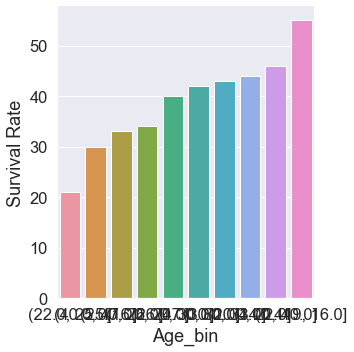

In [25]:
survival_rate('Age_bin')

Here we see that survival rate is highest for the youngest children and then falls off until the age range of 31-36yo are considered. It is then lower for the elderly.

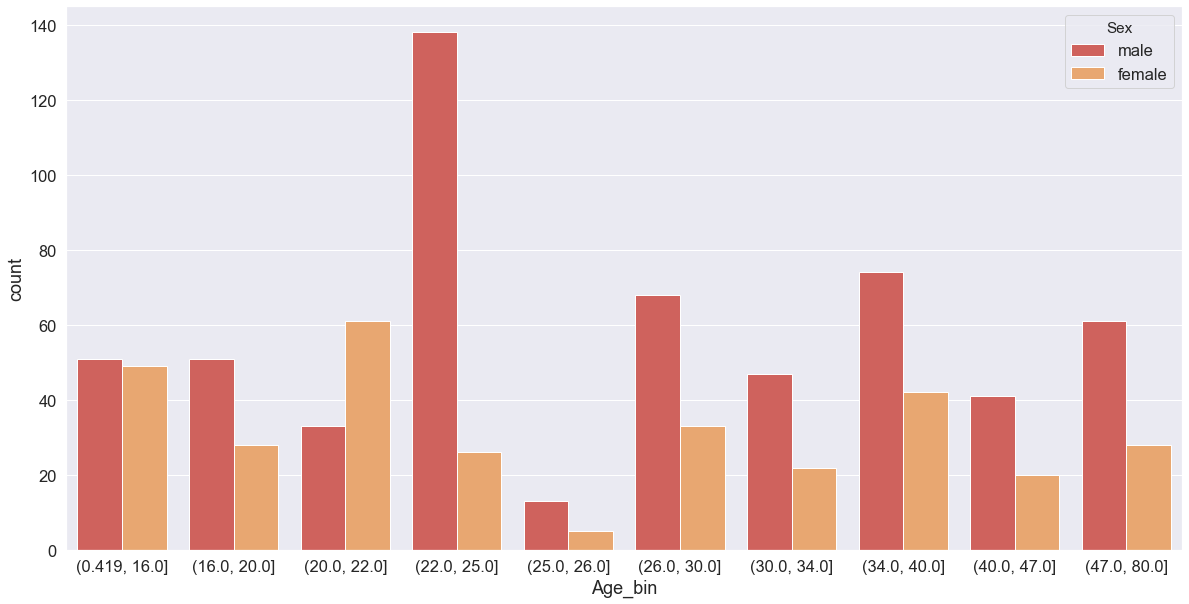

In [26]:
plt.figure(figsize=(20, 10))

sns.countplot(x="Age_bin", hue="Sex", data=titanic_raw)
plt.show()

We will later discretize the `Age`- data up into:

- `Children`: 0 - 16 yo
- `Adolescents`: 16 - 25 yo
- `Middle-Aged`: 25 - 40 yo
- `Older`: 40 - 80 yo

### 2.5 SibSp, Parch and Family

In [27]:
corr_matrix["SibSp"].sort_values(ascending=False)

SibSp          1.000000
Family Size    0.667568
Parch          0.414838
Fare           0.159651
Pclass         0.083081
Survived      -0.035322
Age           -0.308247
Name: SibSp, dtype: float64

The number of siblings/spouses `SibSp` is obviously very strongly related to `Surname Frequency`, `Parch` and `Age`.

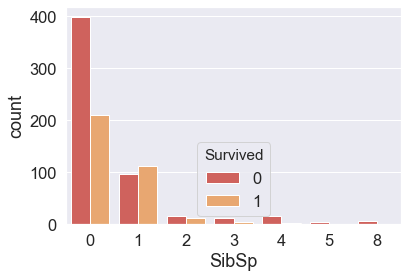

In [28]:
sns.countplot(x="SibSp", hue="Survived", data=titanic_raw)
plt.show()

We can see from this chart that those with no siblings or spouses had the lowest survival rate, relative to the total population in that subset. 

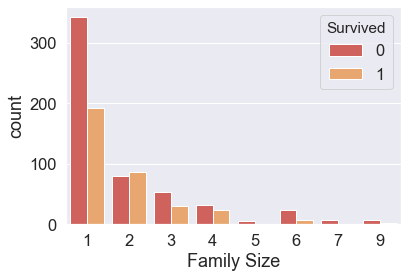

In [29]:
sns.countplot(x="Family Size", hue="Survived", data=titanic_raw)
plt.show()

We can intuitively conclude that these three attributes provide essentially the same information - which passengers were travelling together. We may later be able to remove some of these features due to redundancy.

The Survival Rate for SibSp:1 was 54.0% among 209 passengers
The Survival Rate for SibSp:0 was 35.0% among 608 passengers
The Survival Rate for SibSp:3 was 25.0% among 16 passengers
The Survival Rate for SibSp:4 was 17.0% among 18 passengers
The Survival Rate for SibSp:2 was 46.0% among 28 passengers
The Survival Rate for SibSp:5 was 0.0% among 5 passengers
The Survival Rate for SibSp:8 was 0.0% among 7 passengers


<Figure size 1440x1440 with 0 Axes>

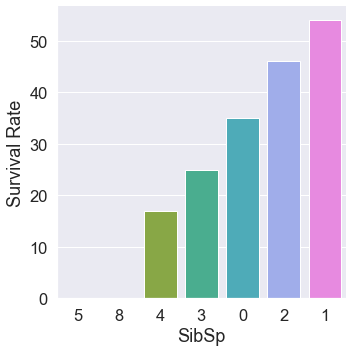

The Survival Rate for Parch:0 was 34.0% among 678 passengers
The Survival Rate for Parch:1 was 55.0% among 118 passengers
The Survival Rate for Parch:2 was 50.0% among 80 passengers
The Survival Rate for Parch:5 was 20.0% among 5 passengers
The Survival Rate for Parch:3 was 60.0% among 5 passengers
The Survival Rate for Parch:4 was 0.0% among 4 passengers
The Survival Rate for Parch:6 was 0.0% among 1 passengers


<Figure size 1440x1440 with 0 Axes>

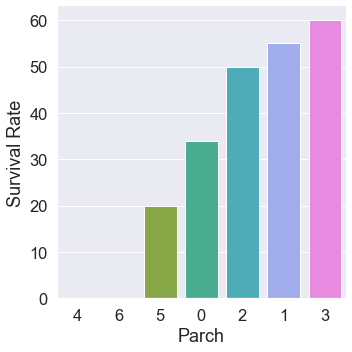

The Survival Rate for Family Size:2 was 52.0% among 166 passengers
The Survival Rate for Family Size:1 was 36.0% among 534 passengers
The Survival Rate for Family Size:3 was 36.0% among 84 passengers
The Survival Rate for Family Size:4 was 43.0% among 56 passengers
The Survival Rate for Family Size:6 was 23.0% among 30 passengers
The Survival Rate for Family Size:9 was 22.0% among 9 passengers
The Survival Rate for Family Size:5 was 0.0% among 5 passengers
The Survival Rate for Family Size:7 was 0.0% among 7 passengers


<Figure size 1440x1440 with 0 Axes>

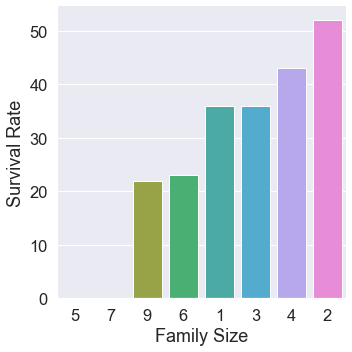

(None, None, None)

In [30]:
survival_rate("SibSp"), survival_rate("Parch"), survival_rate("Family Size")

It is clearer here that the survival rate falls off as the family size grows.

### 2.6 Ticket

In [31]:
titanic_raw["Ticket"].value_counts

<bound method IndexOpsMixin.value_counts of PassengerId
1             A/5 21171
2              PC 17599
3      STON/O2. 3101282
4                113803
5                373450
             ...       
887              211536
888              112053
889          W./C. 6607
890              111369
891              370376
Name: Ticket, Length: 891, dtype: object>

There are many unique values for this attribute, but first we must work with the corresponding data such that only the numericals remain; this is because the coefficients could denote anything from location the ticket was purchased from to the vendor or timeline.

In [32]:
numbers = []
tickets = titanic_raw["Ticket"]

for tick in tickets:
    tick = str(tick)
    nums = tick.split(" ")
    if len(nums) == 3:
        numbers.append(nums[2])
    elif len(nums) == 2:
        numbers.append(nums[1])
    else:
        numbers.append(nums[0])
        
titanic_raw["Ticket"] = numbers        

In [33]:
check = titanic_raw["Ticket"].value_counts().index.tolist()

There are some non-int values under the ticket name `Line` that we must replace. The `Ticket` attribute has many outliers and a large range, therefore the median value would be a suitable replacement for the missing values, so we shall replace the few non-int values for the ticket numbers with the median.

In [34]:
med_calc = []
for row in titanic_raw["Ticket"]:
    if row.isdigit() == True:
        med_calc.append(row)
med_tick = round(np.median([int(i) for i in med_calc]))

titanic_raw["Ticket"].replace(to_replace="LINE", value=int(med_tick), inplace=True)
titanic_raw["Ticket"] = titanic_raw["Ticket"].astype(str).astype(int)

In [35]:
corr_matrix_2 = titanic_raw.corr()

In [36]:
corr_matrix_2["Ticket"].sort_values(ascending=False)

Ticket         1.000000
Pclass         0.284732
Family Size    0.054792
SibSp          0.046591
Parch         -0.032903
Survived      -0.095844
Age           -0.102659
Fare          -0.155913
Name: Ticket, dtype: float64

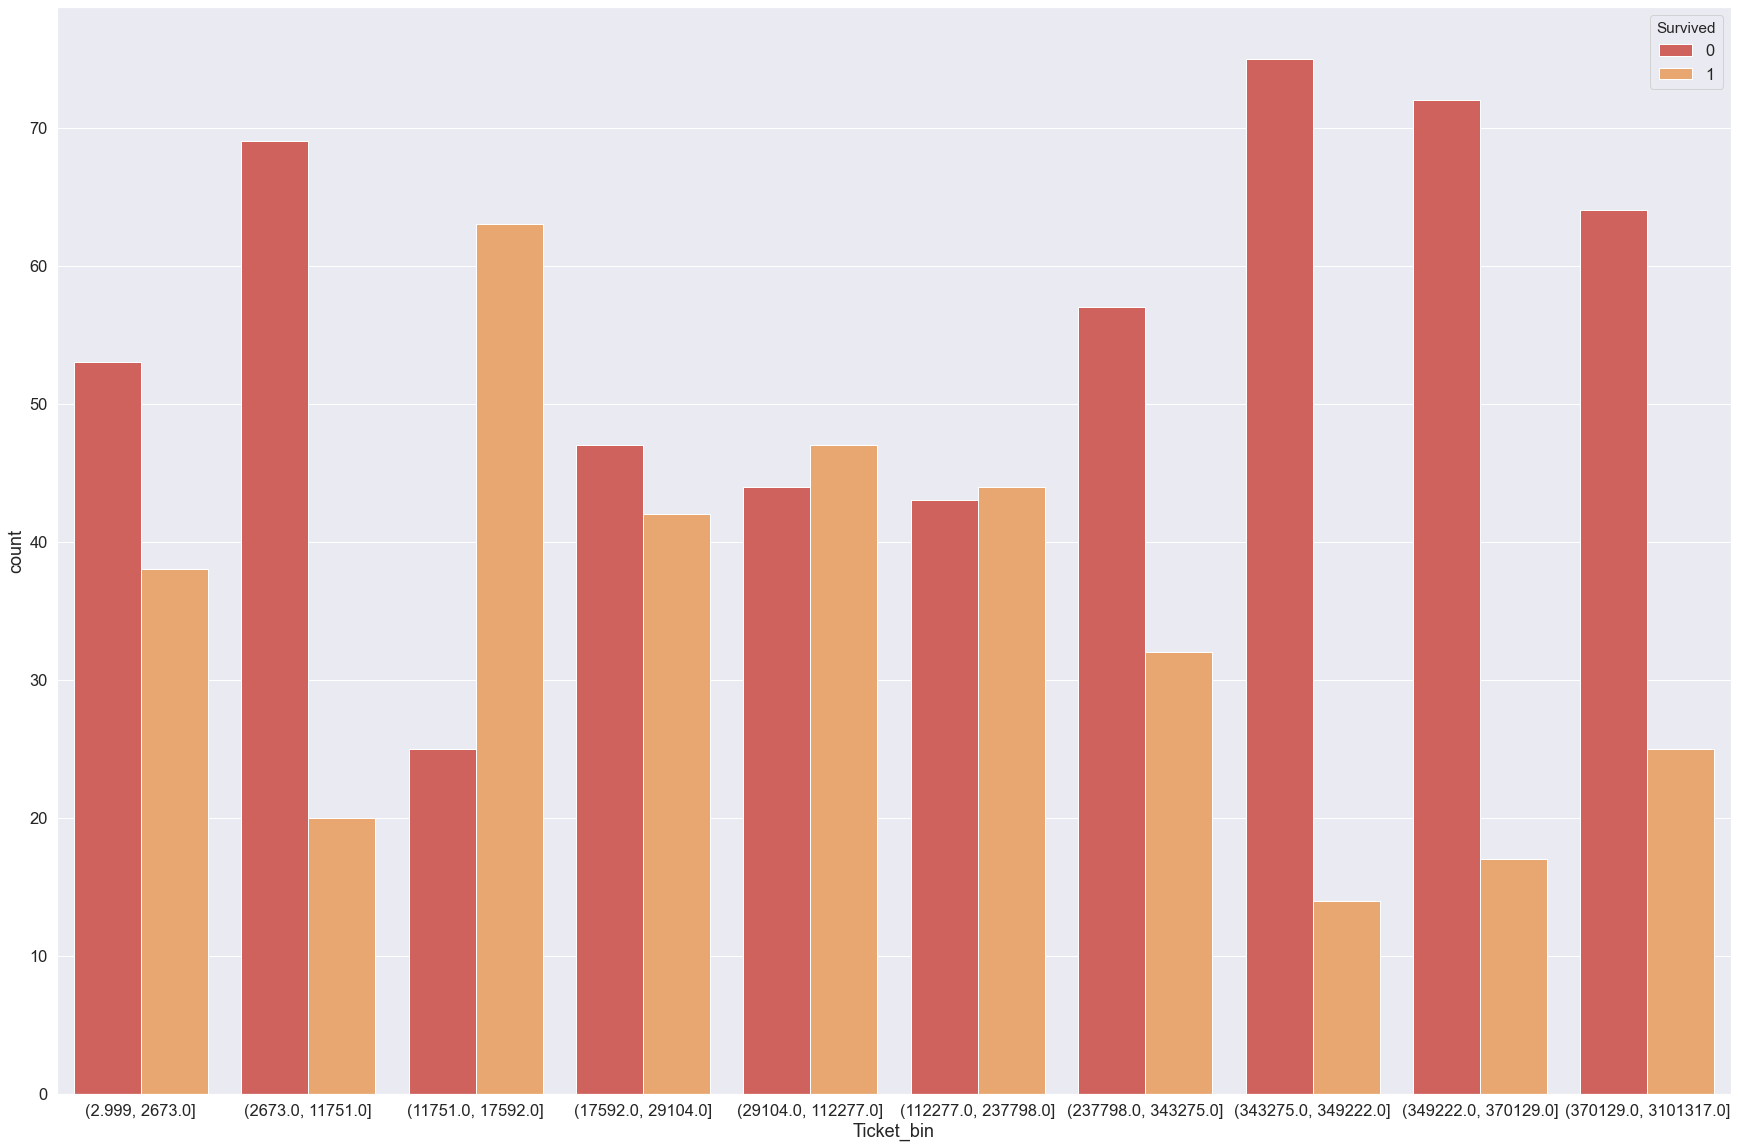

In [37]:
titanic_raw['Ticket_bin'] = pd.qcut(titanic_raw['Ticket'], 10, duplicates='drop')
plt.figure(figsize=(30, 20))
sns.countplot(x="Ticket_bin", hue="Survived", data=titanic_raw)
plt.show()

We see that the mortality rate is particularly high at the extrema of the distribution above, though this might be more explainable due to `Pclass`.

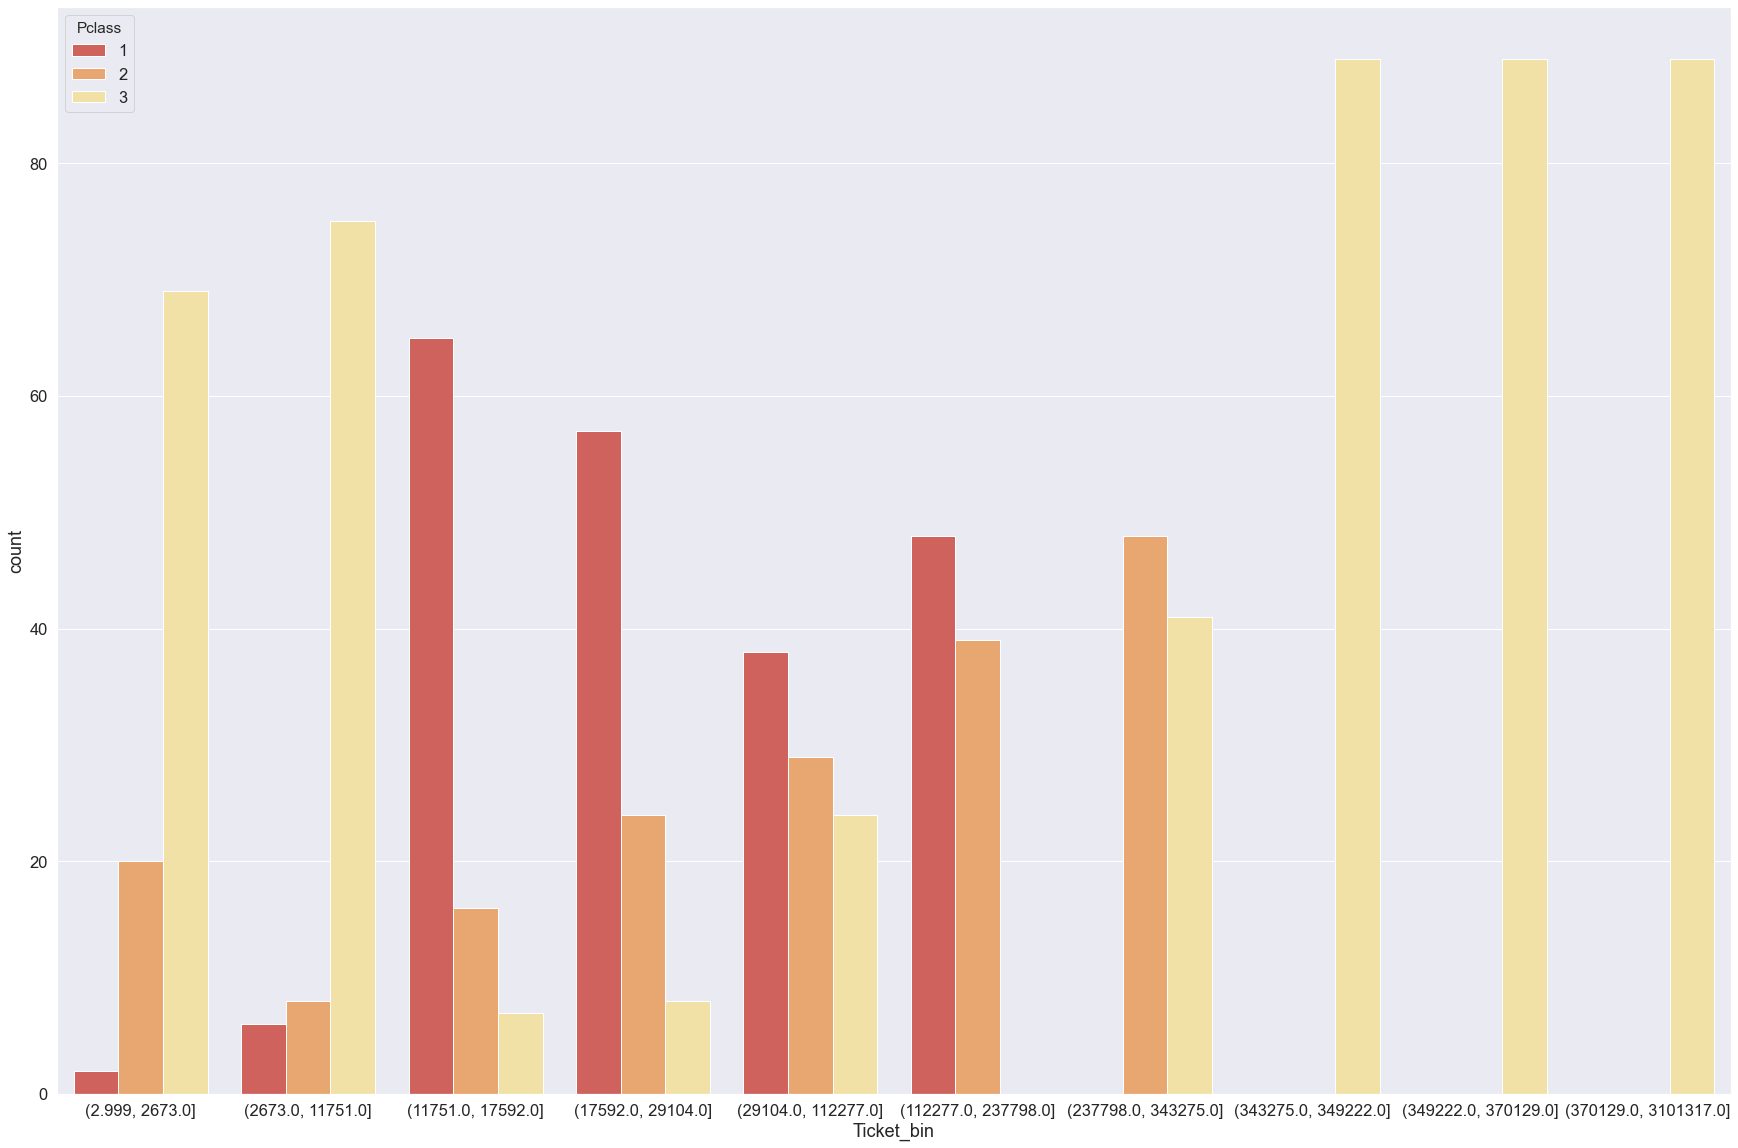

In [38]:
plt.figure(figsize=(30, 20))
sns.countplot(x="Ticket_bin", hue="Pclass", data=titanic_raw)
plt.show()

So we now see that the relationship between the survival of passengers and their ticket numbers are a result of the underlying relationship between `Ticket` and `Pclass`, as is evident from the correlation matrix. The bulk of the lower and higher ticket numbers correspond to the lower class, hence the higher mortality rates. 

A useful attribute could be `Ticket Frequency` as those with the same ticket numbers would have been travelling together:

In [39]:
titanic_raw['Ticket Frequency'] = titanic_raw.groupby('Ticket')['Ticket'].transform('count')

The Survival Rate for Ticket Frequency:1 was 29.0% among 543 passengers
The Survival Rate for Ticket Frequency:2 was 57.0% among 188 passengers
The Survival Rate for Ticket Frequency:4 was 52.0% among 40 passengers
The Survival Rate for Ticket Frequency:3 was 71.0% among 66 passengers
The Survival Rate for Ticket Frequency:7 was 24.0% among 21 passengers
The Survival Rate for Ticket Frequency:5 was 13.0% among 15 passengers
The Survival Rate for Ticket Frequency:6 was 0.0% among 18 passengers


<Figure size 1440x1440 with 0 Axes>

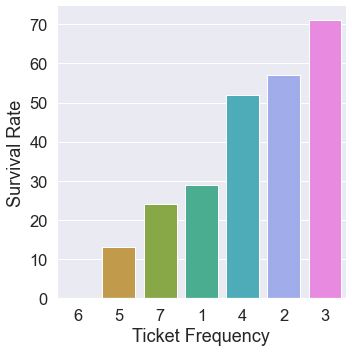

In [40]:
survival_rate('Ticket Frequency')

### 2.7 Embarked

In [41]:
titanic_raw[titanic_raw['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Family Size,Age_bin,Ticket_bin,Ticket Frequency
PassengerId,,,,,,,,,,,,,,,,
62,1,1,female,38.0,0,0,113572,80.0,B28,NaN,Miss,Icard,1,"(34.0, 40.0]","(112277.0, 237798.0]",2
830,1,1,female,62.0,0,0,113572,80.0,B28,NaN,Mrs,Stone,1,"(47.0, 80.0]","(112277.0, 237798.0]",2


These two female passengers have the same ticket number which means the tickets were likely bought together - they know each other and therefore can possibly be grouped. Looking at the charts above, upper-class passengers situated on Deck B that paid $80 for their fare must have boarded the ship from Southampton.

In [42]:
titanic_raw["Embarked"].replace(to_replace=np.nan, value='S', inplace=True)
titanic_raw[(titanic_raw['Ticket'] == 113572)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Family Size,Age_bin,Ticket_bin,Ticket Frequency
PassengerId,,,,,,,,,,,,,,,,
62,1,1,female,38.0,0,0,113572,80.0,B28,S,Miss,Icard,1,"(34.0, 40.0]","(112277.0, 237798.0]",2
830,1,1,female,62.0,0,0,113572,80.0,B28,S,Mrs,Stone,1,"(47.0, 80.0]","(112277.0, 237798.0]",2


### 2.8 Cabin

To be able to study the relationships between `Cabin` and the other features, the values attributed to it must be changed such that only the preceeding letters remain as these likely denote the deck of the ship that the staterooms were allocated to.

In [43]:
cabins = []
cab_raw = titanic_raw["Cabin"]
for cabin in cab_raw:
    cabin = str(cabin)
    cab = cabin[0]
    cabins.append(cab)
    
titanic_raw['Cabin'] = cabins   
titanic_raw['Cabin'].value_counts()    

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

We have now seperated the values in `Cabin` into Decks ranging from A-G with an outlier in Deck T. Let's acquire more information about this passenger.

In [44]:
titanic_raw[titanic_raw['Cabin']=='T']

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Family Size,Age_bin,Ticket_bin,Ticket Frequency
PassengerId,,,,,,,,,,,,,,,,
340,0,1,male,45.0,0,0,113784,35.5,T,S,Mr,Blackwell,1,"(40.0, 47.0]","(112277.0, 237798.0]",1


This passenger was an upper-class individual, we need to investigate which other group he can be absorbed in, i.e which deck's population is he most similar to.

<Figure size 1440x1440 with 0 Axes>

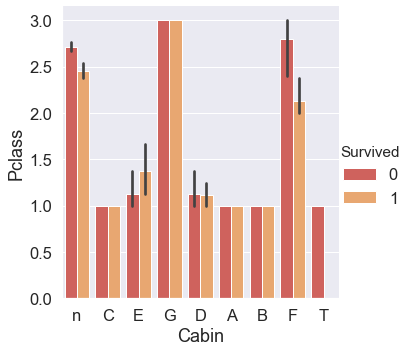

In [45]:
plt.figure(figsize=(20, 20))
sns.catplot(x="Cabin", y="Pclass", hue = "Survived", kind="bar", data=titanic_raw)
plt.show()

We can infer from this plot that Decks A, B and C held the upper-class people, with lower classes being accomodated as a minority further down through Decks D-E and only the second and third-class people being housed on Decks F-G. `n` refers to missing values - the deck number is unknown for these passengers. Therefore, Mr Blackwell from Deck T is similar to passengers on Decks A-C. 

<Figure size 1440x1440 with 0 Axes>

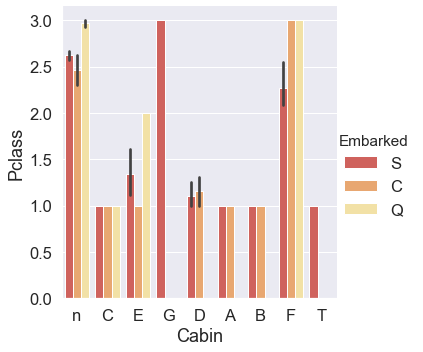

In [46]:
plt.figure(figsize=(20, 20))
sns.catplot(x="Cabin", y="Pclass", hue = "Embarked", kind="bar", data=titanic_raw)
plt.show()

Deck C also contains passengers that embarked from Queenstown, whereas Blackwell embarked from Southampton, therefore it is safe to assume he is most similar to passengers from Decks A-B.

<Figure size 1440x1440 with 0 Axes>

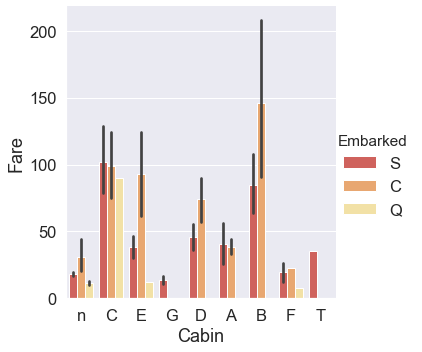

In [47]:
plt.figure(figsize=(20, 20))
sns.catplot(x="Cabin", y="Fare", hue = "Embarked", kind="bar", data=titanic_raw)
plt.show()

From this final plot, we can confirm that Blackwell is most similar to passengers on Deck A, given the price he paid for his `Fare`.

In [48]:
titanic_raw["Cabin"].replace(to_replace="T", value='A', inplace=True)

The Survival Rate for Cabin:n was 30.0% among 687 passengers
The Survival Rate for Cabin:C was 59.0% among 59 passengers
The Survival Rate for Cabin:E was 75.0% among 32 passengers
The Survival Rate for Cabin:G was 50.0% among 4 passengers
The Survival Rate for Cabin:D was 76.0% among 33 passengers
The Survival Rate for Cabin:A was 44.0% among 16 passengers
The Survival Rate for Cabin:B was 74.0% among 47 passengers
The Survival Rate for Cabin:F was 62.0% among 13 passengers


<Figure size 1440x1440 with 0 Axes>

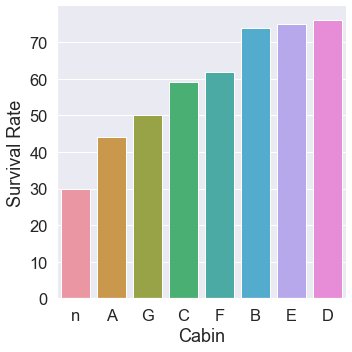

In [49]:
survival_rate('Cabin')

The survival rate of the inhabitants of Deck A is the lowest and Decks B, E and D have the highest survival rates. The lower rates for Decks A and C could also be a result of unfortunate positioning in the ship at the time of catastrophe. All in all, the `Cabin` feature is obviously very important as survival rates vary tremendously among the different decks, hence, we will retain this information in our training and test data.

### 2.9 Fare

In [50]:
titanic_raw['Fare_bin'] = pd.qcut(titanic_raw['Fare'], 15, duplicates='drop')

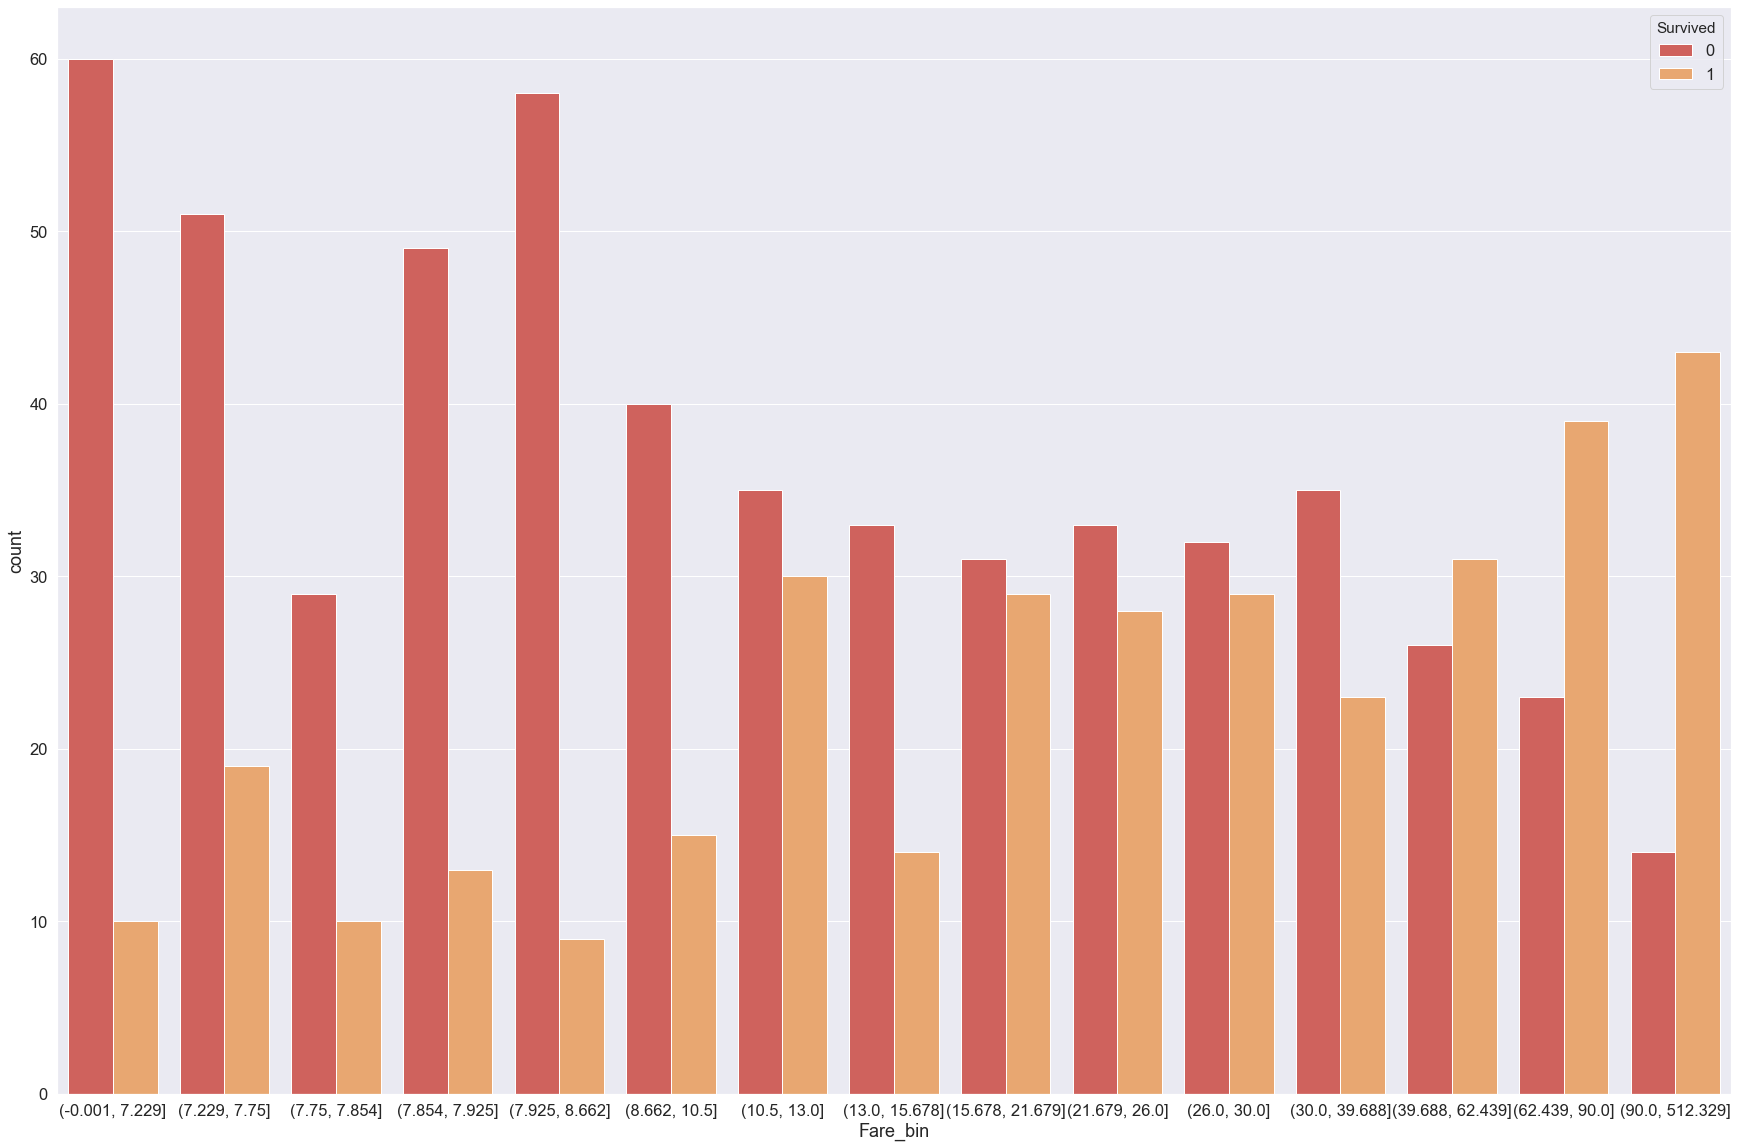

In [51]:
plt.figure(figsize=(30, 20))
sns.countplot(x="Fare_bin", hue = "Survived", data=titanic_raw)
plt.show()

It is evident that following the relationship between `Pclass` and `Survived`, those that paid the most (upper class) has the highest chances of survival, while those that paid the least (lower class) has the highest mortality rate.

We will later discretize the `Fare` ($) - data up into:

- `Cheap`: 0 - 11 
- `Average`: 11 - 40
- `Expensive`: 40 - 90
- `Extremely Expensive`: > 90

### 2.10 Correlation

In [52]:
corr_matrix = titanic_raw.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived            1.000000
Fare                0.257307
Parch               0.081629
Ticket Frequency    0.045631
SibSp              -0.035322
Family Size        -0.049188
Age                -0.059579
Ticket             -0.095844
Pclass             -0.338481
Name: Survived, dtype: float64

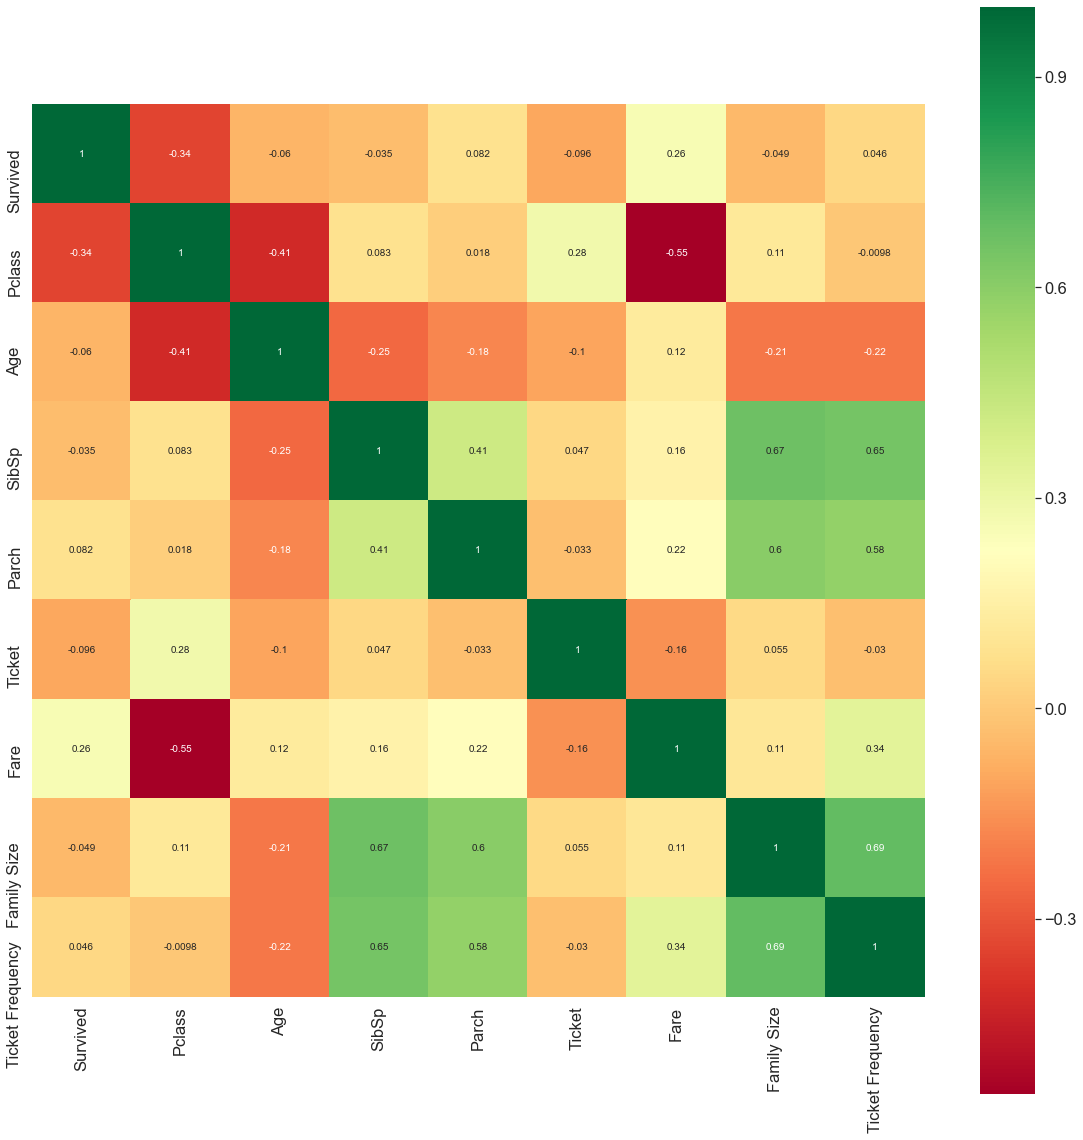

In [53]:
plt.figure(figsize=(20,20))
sns.heatmap(data=corr_matrix, square=True, annot=True, cbar=True, cmap='RdYlGn')
plt.show()

And so we have that `Fare` and `Pclass` in particular are strongly correlated with the survival rate. Naturally, we see the inverse correlation between `Pclass` and `Fare` as those with the higher class (lower value for `Pclass`) would pay higher prices for the fare. We also see that the number of siblings `SibSp` and `Parch` are positively related. There is also an unusually strong inverted relationship between `Pclass` and `Age`:

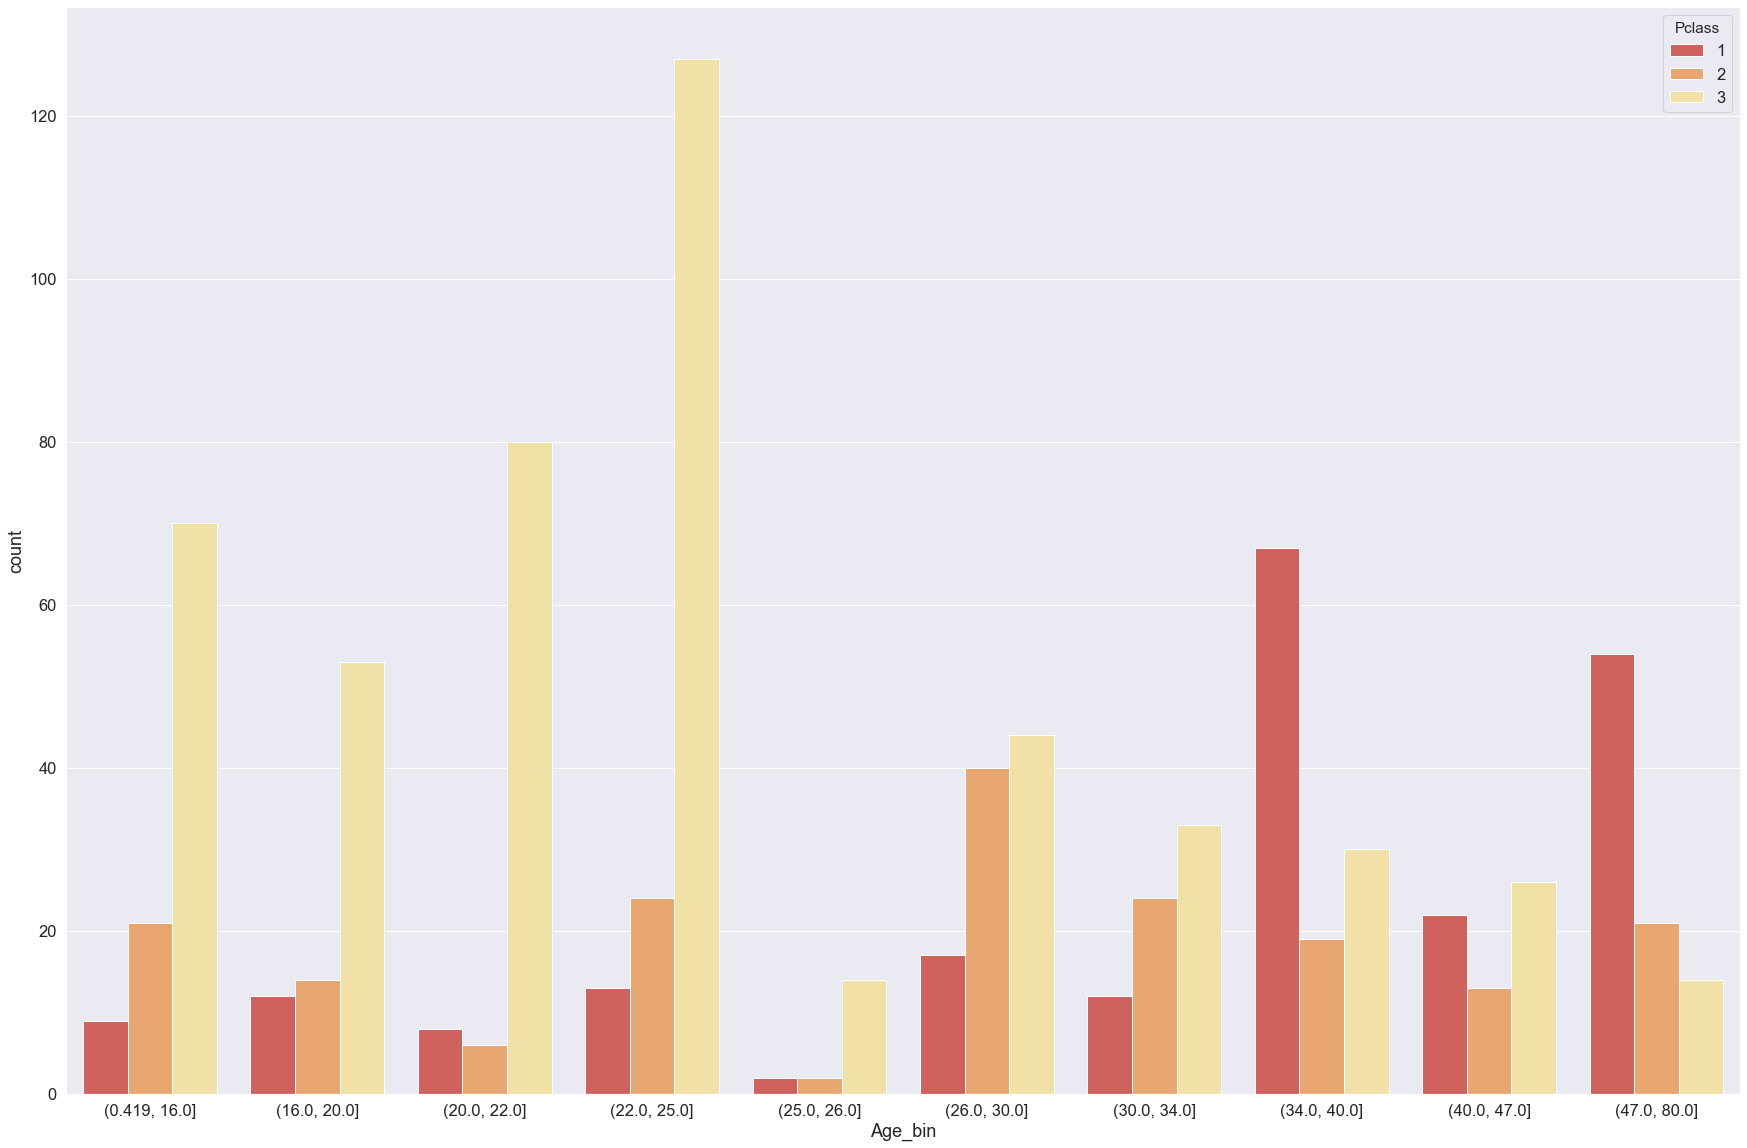

In [54]:
plt.figure(figsize=(30, 20))
sns.countplot(x="Age_bin", hue = "Pclass", data=titanic_raw)
plt.show()

It seems the older the passengers, the lower their class generally.

## 3.  Feature Transformation

In [55]:
titanic_raw.describe()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Family Size,Ticket Frequency
count,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.112424,0.523008,0.381594,2.974932e+05,32.204208,1.882155,1.803591
std,0.486592,0.836071,13.304424,1.102743,0.806057,6.562529e+05,49.693429,1.488014,1.374989
min,0.000000,1.000000,0.420000,0.000000,0.000000,3.000000e+00,0.000000,1.000000,1.000000
25%,0.000000,2.000000,21.500000,0.000000,0.000000,1.487900e+04,7.910400,1.000000,1.000000
50%,0.000000,3.000000,26.000000,0.000000,0.000000,1.122770e+05,14.454200,1.000000,1.000000
75%,1.000000,3.000000,36.000000,1.000000,0.000000,3.470820e+05,31.000000,2.000000,2.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,3.101317e+06,512.329200,9.000000,7.000000


In [56]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 9: 'Large'}
titanic_raw['Family Size'] = titanic_raw['Family Size'].map(family_map)

In [57]:
age_bands = [0, 1, 2, 3]
age_bands_num = [0, 16, 25, 40, 80]
ages = titanic_raw['Age']

In [58]:
titanic_raw['Age'] = pd.cut(ages, age_bands_num, labels=age_bands)

In [59]:
titanic_raw['Fare'] = titanic_raw['Fare'].round()

In [60]:
titanic_raw.describe()

,Survived,Pclass,SibSp,Parch,Ticket,Fare,Ticket Frequency
count,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000,891.000000
mean,0.383838,2.308642,0.523008,0.381594,2.974932e+05,32.214366,1.803591
std,0.486592,0.836071,1.102743,0.806057,6.562529e+05,49.693352,1.374989
min,0.000000,1.000000,0.000000,0.000000,3.000000e+00,0.000000,1.000000
25%,0.000000,2.000000,0.000000,0.000000,1.487900e+04,8.000000,1.000000
50%,0.000000,3.000000,0.000000,0.000000,1.122770e+05,14.000000,1.000000
75%,1.000000,3.000000,1.000000,0.000000,3.470820e+05,31.000000,2.000000
max,1.000000,3.000000,8.000000,6.000000,3.101317e+06,512.000000,7.000000


In [61]:
fare_bands = [0, 1, 2, 3]
fare_bands_num = [0, 11, 40, 90, 513]
fares = titanic_raw['Fare']

In [62]:
titanic_raw['Fare'] = pd.cut(fares, fare_bands_num, labels=fare_bands, include_lowest=True)

In [63]:
titanic_raw.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Family Size,Age_bin,Ticket_bin,Ticket Frequency,Fare_bin
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,male,1,1,0,21171,0,n,S,Mr,Braund,Small,"(20.0, 22.0]","(17592.0, 29104.0]",1,"(7.229, 7.75]"
2,1,1,female,2,1,0,17599,2,C,C,Mrs,Cumings,Alone,"(34.0, 40.0]","(17592.0, 29104.0]",1,"(62.439, 90.0]"
3,1,3,female,2,0,0,3101282,0,n,S,Miss,Heikkinen,Alone,"(25.0, 26.0]","(370129.0, 3101317.0]",1,"(7.854, 7.925]"
4,1,1,female,2,1,0,113803,2,C,S,Mrs,Futrelle,Small,"(34.0, 40.0]","(112277.0, 237798.0]",2,"(39.688, 62.439]"
5,0,3,male,2,0,0,373450,0,n,S,Mr,Allen,Small,"(34.0, 40.0]","(370129.0, 3101317.0]",1,"(7.925, 8.662]"


In [64]:
titanic_raw["Age"] = titanic_raw["Age"].astype(str).astype(int)
titanic_raw["Fare"] = titanic_raw["Fare"].astype(str).astype(int)

In [65]:
titanic_raw.isnull().sum()

Survived            0
Pclass              0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin               0
Embarked            0
Title               0
Surname             0
Family Size         0
Age_bin             0
Ticket_bin          0
Ticket Frequency    0
Fare_bin            0
dtype: int64

In [66]:
titanic_raw.drop(["Ticket", "Surname", "Age_bin", "Ticket_bin", "Fare_bin"], axis=1, inplace=True)

In [67]:
titanic = titanic_raw.drop("Survived", axis=1)
y_train = titanic_raw["Survived"].copy()

In [68]:
titanic.dtypes

Pclass               int64
Sex                 object
Age                  int32
SibSp                int64
Parch                int64
Fare                 int32
Cabin               object
Embarked            object
Title               object
Family Size         object
Ticket Frequency     int64
dtype: object

In [69]:
nums = titanic.select_dtypes(np.number).columns.to_list()
cats = titanic.select_dtypes('object').columns.to_list()

In [70]:
nums,cats

(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Ticket Frequency'],
 ['Sex', 'Cabin', 'Embarked', 'Title', 'Family Size'])

We shall scale our numerical data using `StandardScaler` which is less sensitive to outliers and encode the rest of the categorical datatypes using `OneHotEncoder`.

In [71]:
preprocessing = ColumnTransformer([
    ('num', StandardScaler(), nums),
    ("cat", OneHotEncoder(), cats)
])

In [72]:
x_train = preprocessing.fit_transform(titanic)

In [86]:
cat_cols = preprocessing.transformers_[1][1].get_feature_names(input_features=cats).tolist()
cols = nums + cat_cols  
len(cols)

40

## 4. Random Forest

In [73]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.legend()
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.grid() 

In [74]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(model, x, y):
    res = [rmse(model.predict(x), y),
                model.score(x, y)]
    if hasattr(model, 'oob_score_'): res.append(model.oob_score_)
    print(res)

In [75]:
forest_clf = RandomForestClassifier(random_state=42)
%time forest_clf.fit(x_train, y_train)

Wall time: 28.9 ms


C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [76]:
print_score(forest_clf, x_train, y_train)

[0.29012942659282975, 0.9158249158249159]


In [77]:
cross_val_score(forest_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.8013468 , 0.81818182, 0.83164983])

In [78]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train, cv=3)

forest_matrix = confusion_matrix(y_train, y_train_pred_forest)
forest_matrix

array([[488,  61],
       [102, 240]], dtype=int64)

In [79]:
rec_forest = recall_score(y_train, y_train_pred_forest)
prec_forest = precision_score(y_train, y_train_pred_forest)

prec_forest, rec_forest

(0.7973421926910299, 0.7017543859649122)

In [80]:
y_scores_forest = cross_val_predict(forest_clf, x_train, y_train, cv=3, method="predict_proba")

y_scores_forest = y_scores_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

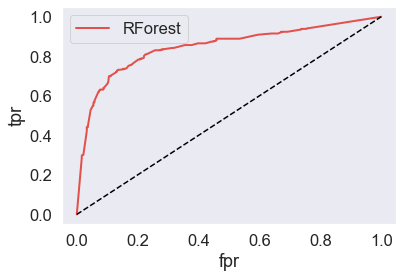

In [81]:
plot_roc_curve(fpr_forest, tpr_forest, label="RForest")
plt.show()

In [82]:
roc_auc_score(y_train, y_scores_forest)

0.8456257522981712

## 5. Fine-Tuning Hyperparameters

Using all our data can lead to overfitting; we have obtained the best accuracy on the training set and this accuracy may not carry over to new data, i.e the test set. A validation set helps diagnose this problem, as we require an independant dataset that was not used to create the model in the first place, which we create below while bearing in mind that we are attempting to somewhat replicate the test set.

In [83]:
param_grid = {
        'n_estimators': [30, 50, 70],
        'max_features':[8, 12, 16],
    }

grid_search = GridSearchCV(forest_clf, param_grid,
                           cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_

In [84]:
grid_search.best_params_

{'max_features': 12, 'n_estimators': 30}

### 5.1 Feature Importance


In [87]:
feature_importances = grid_search.best_estimator_.feature_importances_
fi_list = sorted(zip(cols, feature_importances), reverse=True)

In [88]:
fi_list.sort(key=lambda x: x[1], reverse=True)

In [89]:
fi =  pd.DataFrame(fi_list, columns=["Features", "Feature Importance"])
fi

,Features,Feature Importance
0,Sex_female,0.128103
1,Sex_male,0.108885
2,Title_ Mr,0.091125
3,Pclass,0.089273
4,Age,0.080612
5,Ticket Frequency,0.073793
6,SibSp,0.062285
7,Fare,0.049743
8,Parch,0.037484
9,Title_ Mrs,0.035919


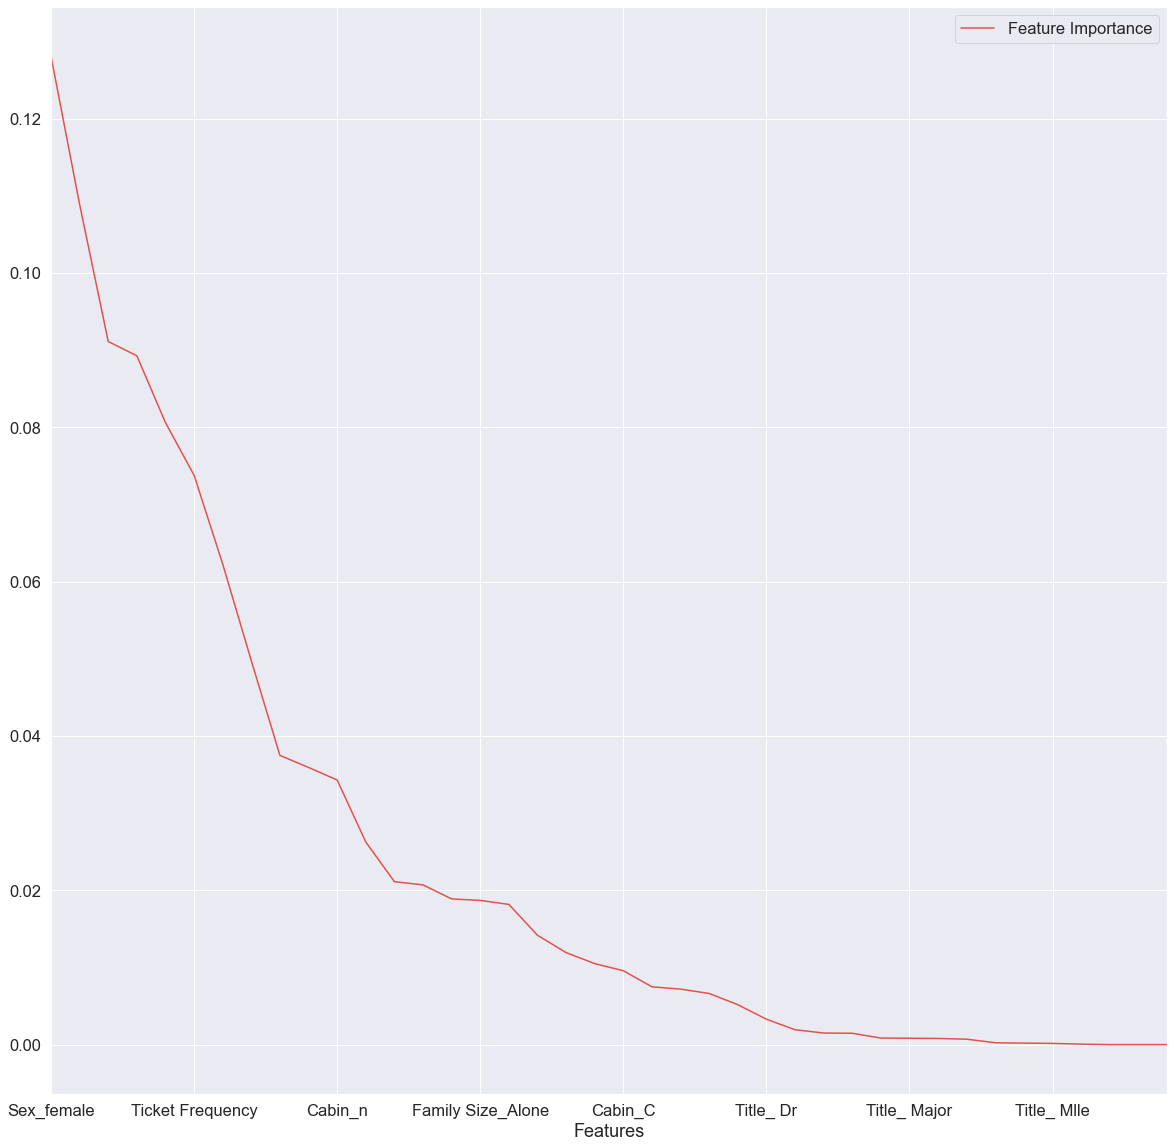

In [90]:
fi.plot('Features', 'Feature Importance', figsize=(20,20))
plt.show()

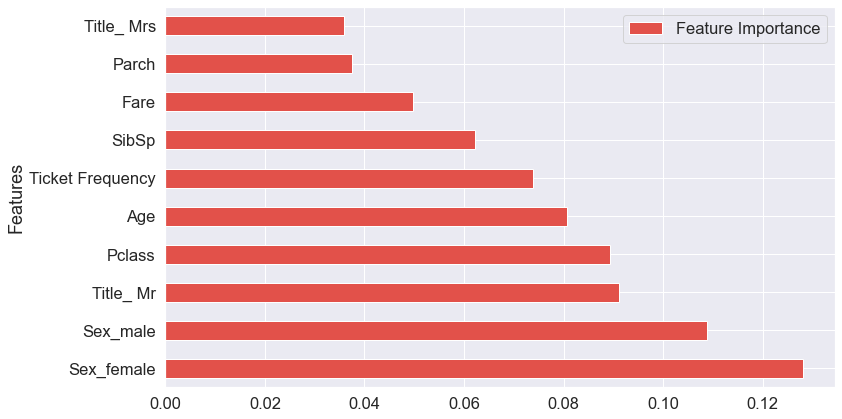

In [91]:
def plot_fi(fi): 
    
    return fi.plot('Features', 'Feature Importance', 'barh', 
                   figsize=(12,7))

plot_fi(fi[:10]);

Let us try removing features with importance < 0.02:

In [92]:
to_keep = fi[fi['Feature Importance'] > 0.02]
to_keep_cols = to_keep['Features'].tolist()

In [93]:
to_keep_cols

['Sex_female',
 'Sex_male',
 'Title_ Mr',
 'Pclass',
 'Age',
 'Ticket Frequency',
 'SibSp',
 'Fare',
 'Parch',
 'Title_ Mrs',
 'Cabin_n',
 'Title_ Miss',
 'Family Size_Small',
 'Embarked_S']

## How to Improve?

Perhaps a way to improve things would be to try and fill in the missing data based on other attributes with high correlation.